In [69]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, Embedding, Bidirectional, Dropout

In [17]:
# load dataset
# the dataset already cleaned. Check the separate .ipynb
twcs = pd.read_csv('twcs_cleaned.csv')
twcs.head()

,tweet,vader_comp,label
0,115712 understand would like assist would need...,0.3612,positive
1,sprintcar propos,0.0000,negative
2,sprintcar sent sever privat messag one respond...,0.0000,negative
3,115712 pleas send us privat messag assist clic...,0.2023,positive
4,sprintcar,0.0000,negative


In [18]:
twcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   tweet       object 
 1   vader_comp  float64
 2   label       object 
dtypes: float64(1), object(2)
memory usage: 64.4+ MB


In [19]:
twcs.shape

(2811774, 3)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Label Count')

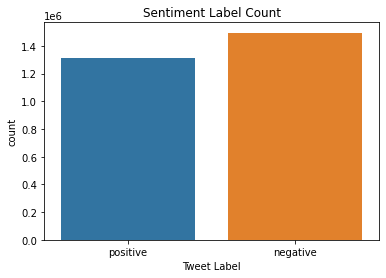

In [20]:
# visualize the count of label
label = twcs['label']

sns.countplot(label)
plt.xlabel("Tweet Label")
plt.title("Sentiment Label Count")

In [21]:
# drop the irrelevant column
twcs.drop('vader_comp',axis=1,inplace=True)

In [22]:
twcs.sample()

,tweet,label
860239,hey 115858 hate ’ iphon crash lose photo video...,negative


In [23]:
twcs.label.value_counts()

negative    1495570
positive    1316204
Name: label, dtype: int64

## MODELLING

### Tokenize

In [24]:
def tokenize_pad_seq(text):
    tokenizer = Tokenizer(num_words=5000, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=50)
    return X, tokenizer

X, tokenizer = tokenize_pad_seq(twcs['tweet'].astype(str))

In [25]:
X.shape

(2811774, 50)

### Split Data

In [49]:
#split data
y = pd.get_dummies(twcs['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print('Shape of X_train Set: {}'.format(X_train.shape))
print('Shape of X_val Set: {}'.format(X_val.shape))
print('Shape of X_test Set: {}'.format(X_test.shape))
print('Shape of y_train Set: {}'.format(y_train.shape))
print('Shape of y_val Set: {}'.format(y_val.shape))
print('Shape of y_test Set: {}'.format(y_test.shape))

Shape of X_train Set: (1799535, 50)
Shape of X_val Set: (449884, 50)
Shape of X_test Set: (562355, 50)
Shape of y_train Set: (1799535, 2)
Shape of y_val Set: (449884, 2)
Shape of y_test Set: (562355, 2)


### Model Building

In [60]:
vocabSize = 5000
embeddingSize = 32
epochs = 10

model = Sequential()
model.add(Embedding(vocabSize, embeddingSize,input_length=X_train.shape[1])) # embedding layer
model.add(Conv1D(filters=32,kernel_size=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32))) #RNN layer
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 32)            1056      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                

In [62]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [63]:
# fit the model
history = model.fit(X_train,y_train,
                    batch_size=64,epochs=10,verbose=1)

Epoch 1/10
28118/28118 [==============================] - 391s 14ms/step - loss: 0.3454 - accuracy: 0.8419
Epoch 2/10
28118/28118 [==============================] - 380s 14ms/step - loss: 0.1597 - accuracy: 0.9556
Epoch 3/10
28118/28118 [==============================] - 376s 13ms/step - loss: 0.1298 - accuracy: 0.9618
Epoch 4/10
28118/28118 [==============================] - 371s 13ms/step - loss: 0.1113 - accuracy: 0.9642
Epoch 5/10
28118/28118 [==============================] - 3466s 123ms/step - loss: 0.1020 - accuracy: 0.9678
Epoch 6/10
28118/28118 [==============================] - 380s 14ms/step - loss: 0.0920 - accuracy: 0.9717
Epoch 7/10
28118/28118 [==============================] - 382s 14ms/step - loss: 0.0837 - accuracy: 0.9747
Epoch 8/10
28118/28118 [==============================] - 451s 16ms/step - loss: 0.0776 - accuracy: 0.9770
Epoch 9/10
28118/28118 [==============================] - 442s 16ms/step - loss: 0.0741 - accuracy: 0.9786
Epoch 10/10
28118/28118 [==========

In [64]:
# evaluate the model
model.evaluate(X_val,y_val,verbose=1)

14059/14059 [==============================] - 52s 4ms/step - loss: 0.0672 - accuracy: 0.9810


[0.0671985074877739, 0.980950653553009]

In [66]:
# the model prediction
y_pred = model.predict(X_test)

17574/17574 [==============================] - 67s 4ms/step


Text(51.0, 0.5, 'Prediction Label')

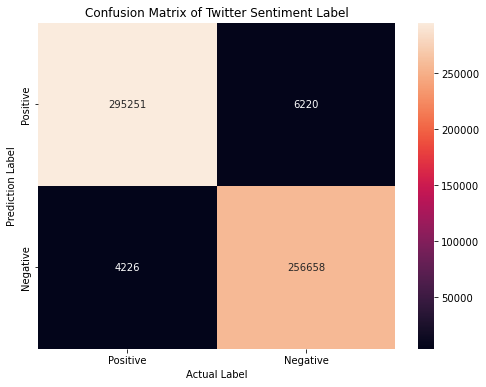

In [70]:
# plot the confusion matrix of the sentiment label

label = ['Positive','Negative']
cm = confusion_matrix(np.argmax(y_pred, axis=1),
                      np.argmax(np.array(y_test),axis=1))

# plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d', xticklabels=label,
            yticklabels=label)
plt.title("Confusion Matrix of Twitter Sentiment Label")
plt.xlabel("Actual Label")
plt.ylabel("Prediction Label")